<a href="https://colab.research.google.com/github/JimKing100/SF_Real_Estate_Project/blob/master/SF%20Map%20Code%20Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install libgeos
%%capture
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

In [0]:
# Install fiona
%%capture
!pip install fiona

In [0]:
# Install geopy
%%capture
!pip install geopy

In [0]:
# Install pysal
%%capture
!pip install -U pysal

In [0]:
# Step 1 libspatialindex install
!apt-get install -qq curl g++ make

In [0]:
# Step 2 libspatialindex install
%%capture
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz

In [0]:
# Step 3 libspatialindex install
import os
os.chdir('spatialindex-src-1.8.5')

In [0]:
# Step 4 libspatialindex install
%%capture
!./configure

In [0]:
# Step 5 libspatialindex install
%%capture
!make

In [0]:
# Step 6 libspatialindex install
%%capture
!make install

In [0]:
# Step 7 libspatialindex install
%%capture
!pip install rtree

In [0]:
# Step 8 libspatialindex install
!ldconfig

In [13]:
# Import libraries
import pandas as pd
import numpy as np

from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

from descartes import PolygonPatch

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep

from itertools import chain
from geopy.geocoders import Nominatim
import fiona
import matplotlib.pyplot as plt

from pysal.viz.mapclassify import NaturalBreaks as nb

/usr/local/lib/python3.6/dist-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"


In [90]:
# Load SF real estate data
initial_data = pd.read_csv('https://raw.githubusercontent.com/JimKing100/SF_Real_Estate_Project/master/data/SF-SFR-Sales-Final1.csv')
print(initial_data.shape)
initial_data.head(5)

(23711, 30)


,longitude,latitude,full_address,city,state,street_no,street_name,street_nox,street_suffix,zip,area,district_no,district_desc,subdist_no,subdist_desc,on_market_data,cdom,orig_list_price,sale_date,sale_price,rooms,baths,beds,sf_source,sf_source_decs,sf,lot_acres,lot_sf,year_built,zoning
0,-122.466620,37.753273,"1878 10th Ave, San Francisco, CA 94122-4602",San Francisco,CA,1878,10th,NaN,Ave,94122,2060,2,SF District 2,2060,2 - Inner Sunset,8/31/11,65,649000,12/22/11,580000,6,1.0,2,T,Per Tax Records,1480,NaN,0,1932,RH1
1,-122.466670,37.753850,"1842 10th Ave, San Francisco, CA 94122-4602",San Francisco,CA,1842,10th,NaN,Ave,94122,2060,2,SF District 2,2060,2 - Inner Sunset,10/8/08,164,679000,3/23/09,509000,0,1.0,2,T,Per Tax Records,920,NaN,0,1908,RH1
2,-122.466700,37.754070,"1829 10th Ave, San Francisco, CA 94122",San Francisco,CA,1829,10th,NaN,Ave,94122,2060,2,SF District 2,2060,2 - Inner Sunset,9/6/13,15,699000,10/11/13,840000,0,1.5,2,T,Per Tax Records,1200,0.0693,3017,1906,RH1
3,-122.466965,37.758057,"1612 10th Ave, San Francisco, CA 94122",San Francisco,CA,1612,10th,NaN,Ave,94122,2060,2,SF District 2,2060,2 - Inner Sunset,6/8/10,9,699900,7/29/10,817000,6,1.0,3,T,Per Tax Records,1800,NaN,0,1914,NaN
4,-122.466910,37.757130,"1671 10th Ave, San Francisco, CA 94122",San Francisco,CA,1671,10th,NaN,Ave,94122,2060,2,SF District 2,2060,2 - Inner Sunset,9/8/11,25,749000,10/6/11,785000,5,1.0,2,T,Per Tax Records,1050,NaN,0,1938,RH2


In [91]:
# Rename subdistr_desc to neighborhood
temp_data = initial_data.rename(columns={'subdist_desc': 'neighborhood'})
temp_data.head(5)
temp_data.dtypes

longitude          float64
latitude           float64
full_address        object
city                object
state               object
street_no            int64
street_name         object
street_nox          object
street_suffix       object
zip                 object
area                 int64
district_no          int64
district_desc       object
subdist_no           int64
neighborhood        object
on_market_data      object
cdom                 int64
orig_list_price      int64
sale_date           object
sale_price           int64
rooms                int64
baths              float64
beds                 int64
sf_source           object
sf_source_decs      object
sf                   int64
lot_acres          float64
lot_sf               int64
year_built           int64
zoning              object
dtype: object

In [0]:
# Fill sf zero values with the average sf by bedroom
averagesf_data = temp_data.groupby('beds').sf.mean()

# Use average sf by bedroom for each 0 value in each bedroom group
for i in range(0, 9): 
  temp_data.loc[(temp_data['sf'] == 0) & (temp_data['beds'] == i), 'sf'] = averagesf_data.loc[i]

# Use 10,000sf for anything over 9 bedrooms
temp_data.loc[temp_data['sf'] == 0, 'sf'] = 10000
temp_data = temp_data.astype({'sf': int})

In [93]:
# Map MLS neighborhood code (e.g. 1010) to shapefile neighborhood id (e.g. '1a')
neighborhood_dict = {1010: '1a', 1020: '1b', 1030: '1c', 1040: '1d', 1050: '1e', 1060: '1f', 1070: '1g',
                     2010: '2a', 2020: '2b', 2030: '2c', 2040: '2d', 2050: '2e', 2060: '2f', 2070: '2g',
                     3010: '3a', 3020: '3b', 3030: '3c', 3040: '3d', 3050: '3e', 3060: '3f', 3070: '3g', 3080: '3h', 3090: '3j',
                     4010: '4a', 4020: '4b', 4030: '4c', 4040: '4d', 4050: '4e', 4060: '4f', 4070: '4g', 4080: '4h', 4090: '4j', 4100: '4k', 4110: '4m', 4120: '4n', 4130: '4p', 4140: '4r', 4150: '4s', 4160: '4t',
                     5010: '5a', 5020: '5b', 5030: '5c', 5040: '5d', 5050: '5e', 5060: '5f', 5070: '5g', 5080: '5h', 5090: '5j', 5100: '5k', 5110: '5m',
                     6010: '6a', 6020: '6b', 6030: '6c', 6040: '6d', 6050: '6e', 6060: '6f',
                     7010: '7a', 7020: '7b', 7030: '7c', 7040: '7d', 
                     8010: '8a', 8020: '8b', 8030: '8c', 8040: '8d', 8050: '8e', 8060: '8f', 8070: '8g', 8080: '8h', 8090: '8j',
                     9010: '9a', 9020: '9c', 9030: '9d', 9040: '9e', 9050: '9f', 9060: '9h', 9070: '9j', 9080: '9g', 
                     10010: '10a', 10020: '10b', 10030: '10c', 10040: '10d', 10050: '10e', 10060: '10f', 10070: '10g', 10080: '10h', 10090: '10j', 10100: '10k', 10110: '10m', 10120: '10n'
                    }
sf_data = temp_data.replace({'subdist_no': neighborhood_dict})

# Create a subset by year
sf_data['year'] = '20' + sf_data['sale_date'].str[-2:]
year_subset = sf_data[sf_data['year'] == '2018']
year_subset.head(5)

,longitude,latitude,full_address,city,state,street_no,street_name,street_nox,street_suffix,zip,area,district_no,district_desc,subdist_no,neighborhood,on_market_data,cdom,orig_list_price,sale_date,sale_price,rooms,baths,beds,sf_source,sf_source_decs,sf,lot_acres,lot_sf,year_built,zoning,year
28,-122.466644,37.753593,"1858 10th Ave, San Francisco, CA 94122",San Francisco,CA,1858,10th,NaN,Ave,94122,2060,2,SF District 2,2f,2 - Inner Sunset,3/29/18,14,995000,5/3/18,1615000,5,1.0,2,S,Per Graphic Artist,1346,0.0689,3000,1921,RH1,2018
36,-122.466840,37.756226,"1711 10th Ave, San Francisco, CA 94122-4625",San Francisco,CA,1711,10th,NaN,Ave,94122,2060,2,SF District 2,2f,2 - Inner Sunset,7/13/18,11,1199000,8/3/18,1400000,4,1.5,2,T,Per Tax Records,1036,0.0473,2060,1951,RH1,2018
39,-122.467190,37.761200,"1449 10th Ave, San Francisco, CA 94122-3602",San Francisco,CA,1449,10th,NaN,Ave,94122,2060,2,SF District 2,2f,2 - Inner Sunset,6/4/18,17,1250000,7/25/18,1410000,0,1.0,2,P,Tax No Autofill,1012,0.0689,0,1906,RH1,2018
41,-122.466675,37.753784,"1847 10th Ave, San Francisco, CA 94122-4601",San Francisco,CA,1847,10th,NaN,Ave,94122,2060,2,SF District 2,2f,2 - Inner Sunset,2/22/18,15,1295000,4/4/18,1705000,6,2.0,2,T,Per Tax Records,1688,0.0689,3000,1927,RH1,2018
61,-122.468070,37.774097,"758 10th Ave, San Francisco, CA 94118",San Francisco,CA,758,10th,NaN,Ave,94118,1020,1,SF District 1,1b,1 - Inner Richmond,9/10/18,14,1799000,10/1/18,2455000,6,2.5,3,T,Per Tax Records,1870,0.0688,2996,1911,RH2,2018


In [95]:
# Create summary data by neighborhood
neighborhood_data = pd.DataFrame({'price_sf': year_subset.groupby('subdist_no').apply(
                                   lambda x: sum(x['sale_price'])/sum(x['sf']))})

# Initialize the neighborhoods that have no data 
for key, val in neighborhood_dict.items():

  if any(neighborhood_data.index.str.contains(val)) == False:
    neighborhood_data.loc[val] = [1]

# Initialize the parks that have no data
neighborhood_data.loc['12a'] = [1]
neighborhood_data.loc['12b'] = [1]
neighborhood_data.loc['12c'] = [1]

neighborhood_data.sort_values(by=['subdist_no'])

,price_sf
subdist_no,
10a,632.683904
10b,754.247089
10c,800.955428
10d,708.920292
10e,701.210105
10f,758.064447
10g,729.868943
10h,798.972582
10j,1.000000


In [0]:
# Download the geo files from github
%%capture
os.chdir('/content')
!wget 'https://github.com/JimKing100/SF_Real_Estate_Project/blob/master/data/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.shp?raw=true'
!wget 'https://github.com/JimKing100/SF_Real_Estate_Project/blob/master/data/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.dbf?raw=true'
!wget 'https://github.com/JimKing100/SF_Real_Estate_Project/blob/master/data/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.prj?raw=true'
!wget 'https://github.com/JimKing100/SF_Real_Estate_Project/blob/master/data/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.shx?raw=true'

In [0]:
# Rename the geofiles
!mv '/content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.shp?raw=true' /content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.shp
!mv '/content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.dbf?raw=true' /content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.dbf
!mv '/content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.prj?raw=true' /content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.prj
!mv '/content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.shx?raw=true' /content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.shx

In [0]:
# Load the geo files
shp = fiona.open('/content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898.shp')

In [0]:
# Extract map boundaries
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
# width, height of map
w, h = coords[2] - coords[0], coords[3] - coords[1]

In [0]:
# Create the basemap
m = Basemap(
    projection='tmerc',
    lon_0=-122.,
    lat_0=37.7,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

(92,
 5,
 [-122.51494807968153, 37.70808933741858, 0.0, 0.0],
 [-122.35696603928594, 37.811573987414484, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x7fd68eb98080>)

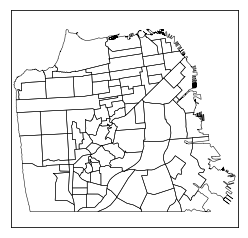

In [100]:
# Read the shape file
m.readshapefile(
    '/content/geo_export_965a7270-cc48-41f8-a2cf-b2b7fce81898',
    'SF',
    color='black',
    zorder=2)

In [0]:
# Change parks to non-existing MLS region 12 in shape file
m.SF_info[24]['nid'] = '12a' # Golden Gate Park
m.SF_info[73]['nid'] = '12b' # Presidio
m.SF_info[91]['nid'] = '12c' # Lincoln Park

In [102]:
# Fill the map dataframe with values
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.SF],
    'nbrhood_name': [nbrhood['nbrhood'] for nbrhood in m.SF_info],
    'nid': [nid['nid'] for nid in m.SF_info],
    'price_sf': [neighborhood_data.loc[nid['nid'], 'price_sf'] for nid in m.SF_info]
})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000

# Draw neighborhoods with polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#808080',
    ec='#111111', lw=.5, alpha=1,
    zorder=4))

df_map.head()

,poly,nbrhood_name,nid,price_sf,area_m,area_km,patches
0,"POLYGON ((7715.167703048319 8393.557469683687,...",Alamo Square,6e,934.343434,3.245940e+05,3.245940,"PathPatch16((7715.17, 8393.56) ...)"
1,"POLYGON ((6133.610085287233 8930.101370827508,...",Anza Vista,6a,735.183561,2.888324e+05,2.888324,"PathPatch10((6133.61, 8930.1) ...)"
2,"POLYGON ((4605.819118328618 3648.076924674302,...",Balboa Terrace,4a,829.295399,2.185278e+05,2.185278,"PathPatch23((4605.82, 3648.08) ...)"
3,"POLYGON ((11395.04759510169 5621.170830157842,...",Bayview,10a,632.683904,5.015361e+06,50.153607,"PathPatch562((11395, 5621.17) ...)"
4,"POLYGON ((9969.501990147706 5508.065990637874,...",Bernal Heights,9a,1081.791419,2.827494e+06,28.274940,"PathPatch61((9969.5, 5508.07) ...)"


In [0]:
#Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series([Point(m(mapped_x,mapped_y)) for mapped_x, mapped_y in zip(sf_data['longitude'],sf_data['latitude'])])
plt_points = MultiPoint(list(map_points.values))
    

<Figure size 432x288 with 0 Axes>

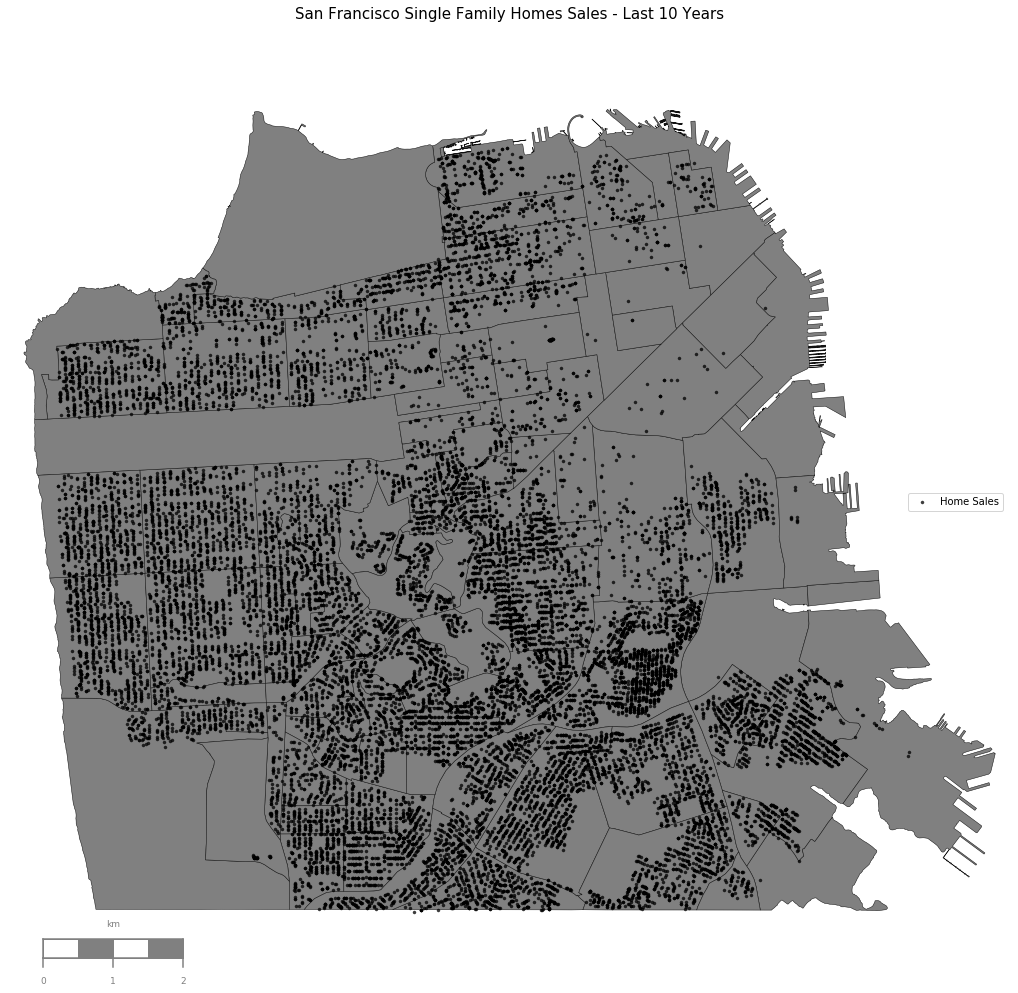

In [28]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w', frame_on=False)

dev = m.scatter(
    [geom.x for geom in map_points],
    [geom.y for geom in map_points],
    10, marker='o', lw=.25,
    facecolor='black', edgecolor='black',
    alpha=0.75, antialiased=True,
    label='Home Sales', zorder=3)

ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

m.drawmapscale(
    coords[0] + 0.015, coords[1] - 0.005,
    coords[0], coords[1],
    2.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#808080',
    fontcolor='#808080',
    zorder=5)

plt.tight_layout()
plt.legend(loc="center right")
plt.title("San Francisco Single Family Homes Sales - Last 10 Years", size=15)
fig.set_size_inches(15,15)
plt.show()

In [0]:
# Calculate Jenks natural breaks for price_sf
breaks = nb(df_map[df_map['price_sf'].notnull()].price_sf.values,
            initial=300,
            k=10)

In [0]:
# the notnull method lets us match indices when joining
jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=df_map[df_map['price_sf'].notnull()].index)
df_map.drop("jenks_bins", inplace=True, axis=1, errors="ignore")
df_map = df_map.join(jb)
df_map.jenks_bins.fillna(-1, inplace=True)

# assign labels to the colorbar based on the natural breaks bins
jenks_labels = ["$%0.0f Price/SF" % b for b in breaks.bins]

<Figure size 432x288 with 0 Axes>

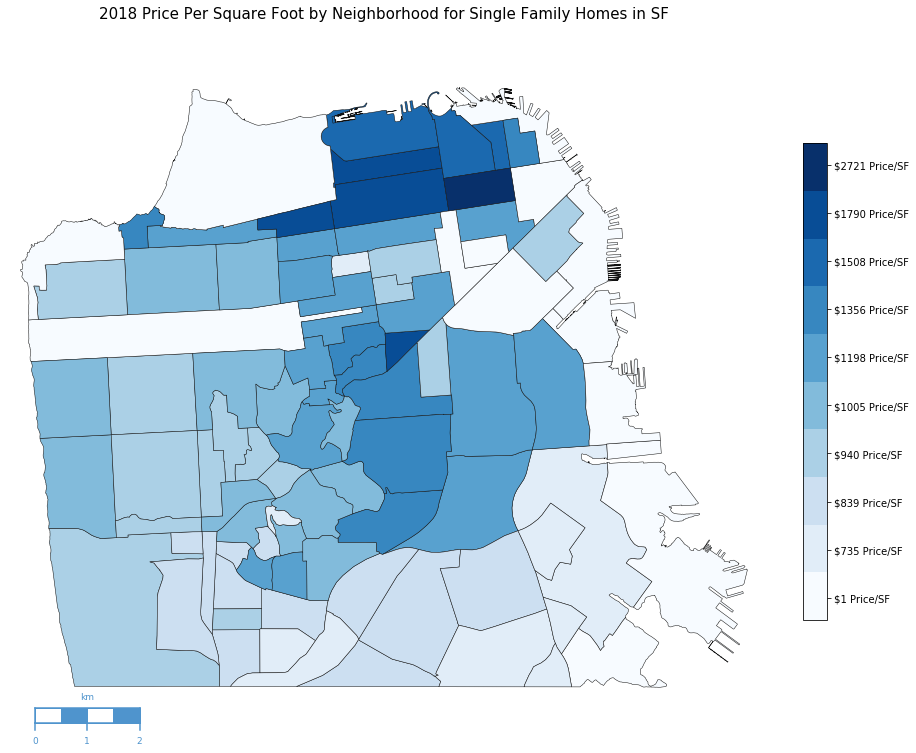

In [107]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.cm as cm

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w', frame_on=False)

# use a blue color ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues')
pc = PatchCollection(df_map['patches'], match_original=True)

# impose our color map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['jenks_bins'].values)))
ax.add_collection(pc)

# Convenience functions for working with color ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in range(N + 1)]
    return LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

#Add a color bar
cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
cb.ax.tick_params(labelsize=10)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.015, coords[1] - 0.005,
    coords[0], coords[1],
    2.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#4F94CD',
    fontcolor='#4F94CD',
    zorder=5)

plt.tight_layout()
plt.title('2018 Price Per Square Foot by Neighborhood for Single Family Homes in SF', size=15)
fig.set_size_inches(15, 15)
plt.show()